<a href="https://colab.research.google.com/github/distributed-information-bottleneck/distributed-information-bottleneck.github.io/blob/main/chaos/Chaos_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Code to reproduce "Optimized measurements of chaotic dynamical systems via the information bottleneck"
Kieran Murphy & Dani Bassett
Nov 8 2023
'''

In [2]:
import chaos_data
import ctw
import sys
sys.path.append("..")

import utils, models

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import scipy.ndimage as nim

from matplotlib import cm
from scipy import optimize
import os
from sklearn.cluster import KMeans
from scipy import special
import glob
import time

default_mpl_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
partition_colors = ['#003f5c', '#F59F00', '#BF211E', '#489FB5']

dataset_dir = './trajectory_data'
if not os.path.exists(dataset_dir):
  os.mkdir(dataset_dir)

outputs_dir = './outputs'
if not os.path.exists(outputs_dir):
  os.mkdir(outputs_dir)

entropy_rate_dict = {'logistic': 0.5203,
                    'henon': 0.6048,
                    'ikeda': 0.726,
                    }


In [3]:
def create_info_bott_encoder(input_dimensionality, output_dimensionality, **encoder_params):
  number_positional_encoding_frequencies = encoder_params.get('number_positional_encoding_frequencies', 0)
  positional_encoding_frequencies = 2**np.arange(1, number_positional_encoding_frequencies+1)
  encoder_arch_spec = encoder_params.get('encoder_arch_spec', [128]*2)
  activation_function = encoder_params.get('activation_function', 'leaky_relu')
  info_bott_encoder = tf.keras.Sequential([tf.keras.layers.Input((input_dimensionality,)), models.PositionalEncoding(positional_encoding_frequencies)] +
                        [tf.keras.layers.Dense(number_units, activation_function) for number_units in encoder_arch_spec] +
                        [tf.keras.layers.Dense(2*output_dimensionality)])
  return info_bott_encoder

# Generate the trajectory data

In [6]:
# This will take a few minutes; feel free to cut the eval size down by a factor of 10 if you don't care too much about the entropy estimates
system_names = ['logistic', 'henon', 'ikeda']
for system_name in system_names:
  for file_appendix, trajectory_length in [('train', 10**6), ('eval', 2*10**7)]:
    out_fname = os.path.join(dataset_dir, f'{system_name}_{file_appendix}.npy')
    if os.path.exists(out_fname):
      print(f'{out_fname} already exists.')
      continue
    trajectory = chaos_data.generate_data(system_name, number_iterations=trajectory_length)
    if np.any(np.std(trajectory[-10:], axis=0) < 1e-3):
      raise ValueError('Trajectory froze at a fixed point, please run again.')
    np.save(out_fname, trajectory)
    print(f'Saved {out_fname}.')

./trajectory_data/logistic_train.npy already exists.
./trajectory_data/logistic_eval.npy already exists.
./trajectory_data/henon_train.npy already exists.
./trajectory_data/henon_eval.npy already exists.
./trajectory_data/ikeda_train.npy already exists.
./trajectory_data/ikeda_eval.npy already exists.


# Entropy rate of random partitions of the Ikeda map (Fig 1)


H(U) = 0.2898 bits.  Measuring entropy rate.
Entropy rate=0.266045+-0.000265


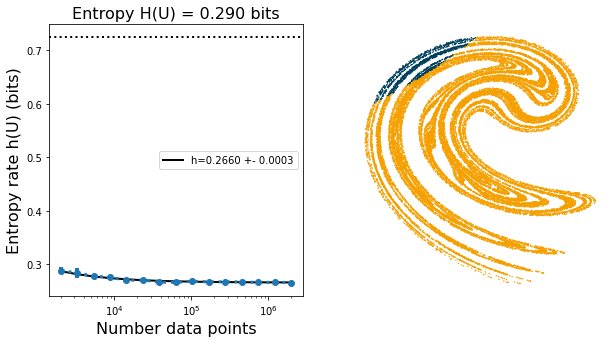

Saved! Time taken: 76.344 sec
H(U) = 0.9079 bits.  Measuring entropy rate.
Entropy rate=0.635426+-0.000972


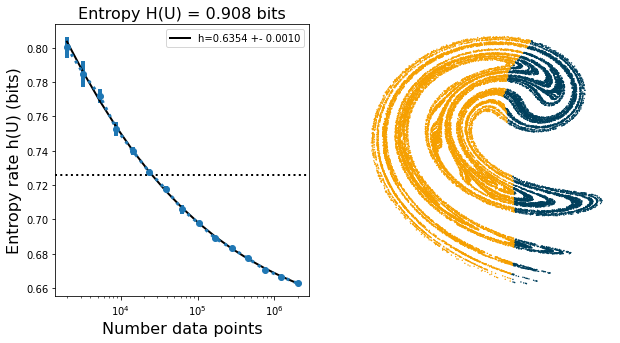

Saved! Time taken: 50.220 sec
H(U) = 0.9270 bits.  Measuring entropy rate.
Entropy rate=0.644225+-0.001233


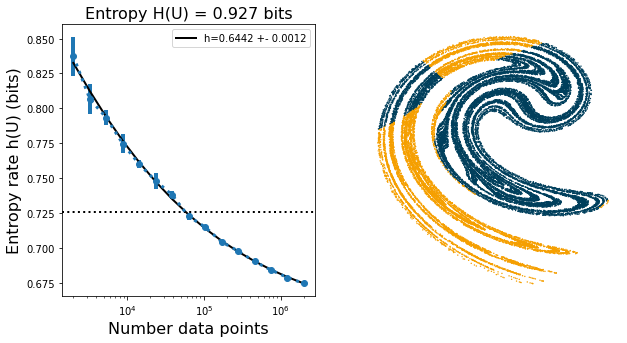

Saved! Time taken: 49.827 sec
H(U) = 0.8931 bits.  Measuring entropy rate.
Entropy rate=0.605440+-0.001150


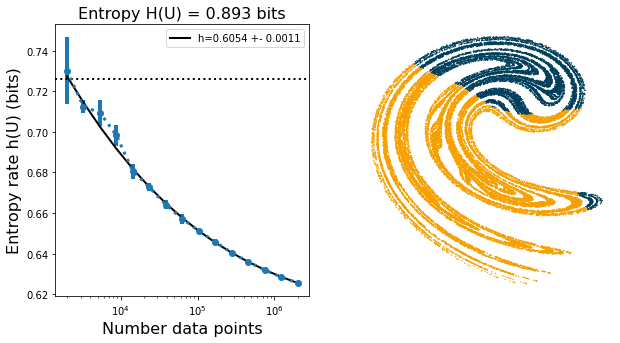

Saved! Time taken: 52.903 sec
H(U) = 0.9799 bits.  Measuring entropy rate.
Entropy rate=0.621881+-0.000781


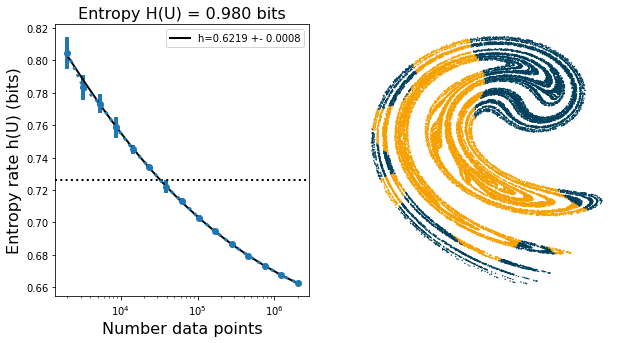

Saved! Time taken: 51.152 sec
H(U) = -0.0000 bits, below threshold. Skipping.
H(U) = 1.1069 bits.  Measuring entropy rate.
Entropy rate=0.629593+-0.001226


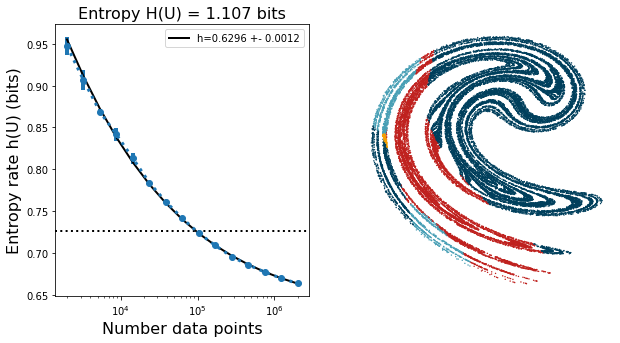

Saved! Time taken: 58.569 sec
H(U) = 0.8193 bits.  Measuring entropy rate.
Entropy rate=0.612869+-0.001559


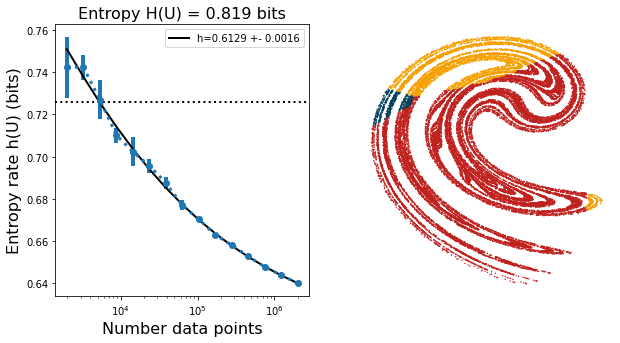

Saved! Time taken: 59.915 sec
H(U) = 0.3360 bits.  Measuring entropy rate.
Entropy rate=0.291772+-0.001203


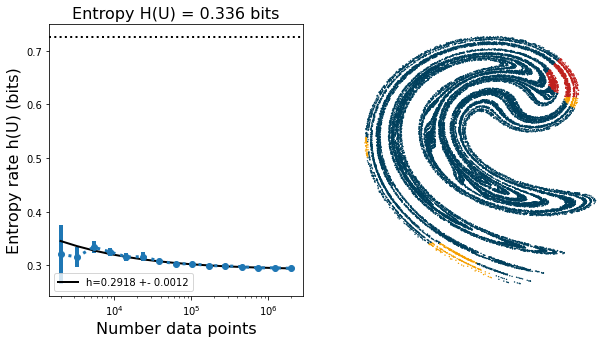

Saved! Time taken: 89.902 sec
H(U) = 0.6673 bits.  Measuring entropy rate.
Entropy rate=0.555788+-0.001122


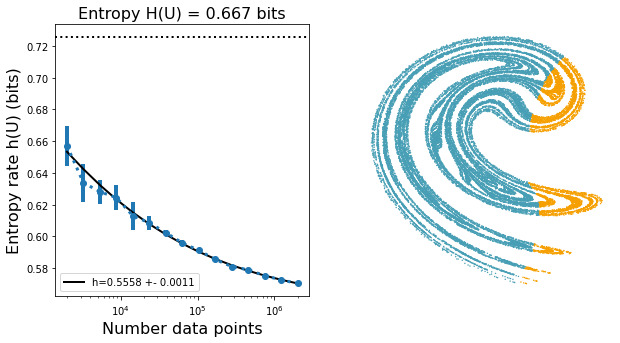

Saved! Time taken: 63.849 sec
H(U) = 1.4861 bits.  Measuring entropy rate.
Entropy rate=0.688477+-0.003525


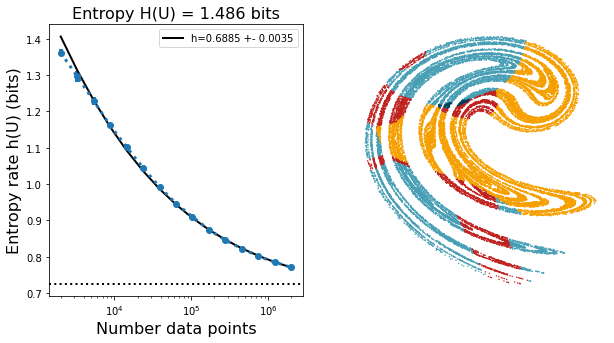

Saved! Time taken: 56.575 sec
H(U) = 1.2743 bits.  Measuring entropy rate.
Entropy rate=0.640085+-0.000725


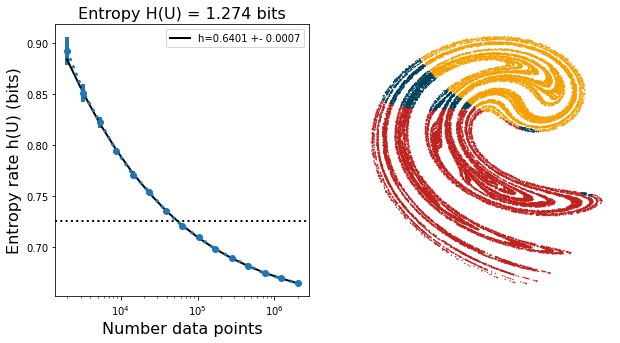

Saved! Time taken: 59.967 sec


In [15]:
# Make random partitions by projecting points through N-layer MLPs
# Measure the single timestep entropy H(U) and entropy rate h_\infty(u) of each
system_name = 'ikeda'
h_ks = entropy_rate_dict[system_name]
entropy_single_timestep_all, entropy_rate_all = [[], []]
# By default, just save the entropy and entropy rate
# but if you want to save a sampling of point assignments for visualizing,
# change the following to True
save_point_assignments = False

random_partition_outdir = os.path.join(
    outputs_dir,
    f'randomly_generated_partitions_{system_name}')
if not os.path.exists(random_partition_outdir):
  os.mkdir(random_partition_outdir)

# Load the evaluation trajectory for estimating the entropy rate
data_arr_eval = np.load(os.path.join(dataset_dir, f'{system_name}_eval.npy'))
input_dimension = data_arr_eval.shape[-1]

# Weights and biases are initialized from Gaussians with the following params:
weight_mean = bias_mean = 0.05
weight_std = bias_std = 0.5
weight_initializer = tf.keras.initializers.random_normal(mean=weight_mean,
                                                         stddev=weight_std)
bias_initializer = tf.keras.initializers.random_normal(mean=bias_mean,
                                                       stddev=bias_std)

units_per_mlp_layer = 64

# The parameters we used for estimating the entropy rate
# Evaluate the CTW entropy rate for different length sequences
# and randomly sample each length 5x
number_data_points_to_evaluate_entropy = np.logspace(np.log10(2000), np.log10(2_000_000), 15, dtype=np.int32)
number_rand_draws_for_entropy = 5

# The way we'll take an output vector and discretize it: just take the axis with
# the largest magnitude
def convert_vec_to_code(outputs):
  encoding_indices = tf.argmax(tf.math.abs(outputs), axis=-1)
  return encoding_indices

number_random_repeats = 1  # this was 20 for the scatter plot of fig 1
for rand_iter in range(number_random_repeats):
  for alphabet_size in [2, 4]:  # the number of colors in the partition
    for number_mlp_layers in [1, 2, 3]:
      for activation_fn in ['tanh', 'relu']:
        out_fname_png = os.path.join(
            random_partition_outdir,
            f'{number_mlp_layers}layers_{activation_fn}_{alphabet_size}alphabet_{rand_iter}.png')
        if os.path.exists(out_fname_png):
          continue
        ct = time.time()  # time the loop
        # Create the MLP
        hidden_layer_sizes = [units_per_mlp_layer]*number_mlp_layers
        layers = [tf.keras.layers.Input(input_dimension)]
        for hidden_dimension in hidden_layer_sizes:
          layers += [tf.keras.layers.Dense(hidden_dimension,
                                           activation=activation_fn,
                                           kernel_initializer=weight_initializer,
                                           bias_initializer=bias_initializer)]
        layers += [tf.keras.layers.Dense(alphabet_size)]
        rand_net = tf.keras.Sequential(layers)
        # Symbolize (i.e., assign the points to a partition)
        # `convert_vec_to_code` just selects the axis of the output vector with largest magnitude
        chunk_size = 1_000_000
        symbolic_sequence = []
        for data_ind_start in range(0, data_arr_eval.shape[0], chunk_size):
          data_ind_end = min(data_ind_start+chunk_size, data_arr_eval.shape[0]+1)
          symbolic_sequence.append(np.uint8(
              convert_vec_to_code(
                  rand_net(data_arr_eval[data_ind_start:data_ind_end]))))
        symbolic_sequence = np.concatenate(symbolic_sequence, 0)
        entropy_single_timestep = utils.compute_entropy(symbolic_sequence)
        if entropy_single_timestep < 0.1:  # skip this part if ~the whole attractor is one color
          print(f'H(U) = {entropy_single_timestep:.4f} bits, below threshold. Skipping.')
          continue
        print(f'H(U) = {entropy_single_timestep:.4f} bits.  Measuring entropy rate.')

        entropy_rate_values = []

        for number_data_points in number_data_points_to_evaluate_entropy:
          for _ in range(number_rand_draws_for_entropy):
            start_ind = np.random.choice(len(symbolic_sequence)-number_data_points)
            partial_seq = symbolic_sequence[start_ind:start_ind+number_data_points]
            entropy_rate_values.append(ctw.estimate_entropy(partial_seq, alphabet_size))
        entropy_rate_values = np.reshape(entropy_rate_values, [-1, number_rand_draws_for_entropy])
        # Use the statistics of the multiple values in the fitting
        entropy_rate_values_mean = entropy_rate_values.mean(1)
        entropy_rate_values_err = entropy_rate_values.std(1)

        # Initial parameters, for h_inf (entropy_rate), gamma, c in Schurmann and Grassberger 1995:
        # h(N) = h_inf + np.log2(N) / (N ** gamma) / np.abs(c)
        p0 = [1, 0.5, 1]
        fit_vals, pcov = optimize.curve_fit(utils.entropy_rate_scaling_ansatz,
                                            number_data_points_to_evaluate_entropy,
                                            entropy_rate_values_mean,
                                            p0=p0,
                                            sigma=entropy_rate_values_err)
        fit_errs = np.sqrt(np.diag(pcov))
        entropy_rate = fit_vals[0]
        entropy_rate_err = fit_errs[0]
        print(f'Entropy rate={entropy_rate:.6f}+-{entropy_rate_err:.6f}')

        entropy_single_timestep_all.append(entropy_single_timestep)
        entropy_rate_all.append(entropy_rate)

        # Plot the entropy rate fit and the partition
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.errorbar(number_data_points_to_evaluate_entropy,
                      entropy_rate_values_mean,
                      yerr=entropy_rate_values_err,
                      marker='o', markersize=6, ls=':', lw=3, elinewidth=4)

        plt.plot(number_data_points_to_evaluate_entropy,
                  utils.entropy_rate_scaling_ansatz(
                    number_data_points_to_evaluate_entropy, *fit_vals),
                  'k', lw=2,
                  label=f'h={entropy_rate:.4f} +- {entropy_rate_err:.4f}')
        plt.axhline(h_ks, ls=':', lw=2, color='k')
        plt.xscale('log')
        plt.xlabel('Number data points', fontsize=16)
        plt.ylabel('Entropy rate h(U) (bits)', fontsize=16)
        plt.title(f'Entropy H(U) = {entropy_single_timestep:.3f} bits', fontsize=16)
        plt.legend()

        plt.subplot(122)
        number_scatter_points = 32000
        positions_viz = data_arr_eval[:number_scatter_points]
        symbolic_sequence_viz = symbolic_sequence[:number_scatter_points]
        colors = [partition_colors[ind] for ind in symbolic_sequence_viz]
        plt.scatter(*positions_viz.T, s=2, c=colors, marker='o', lw=0)
        plt.axis('off')

        plt.savefig(out_fname_png)
        plt.show()

        out_fname_npz = os.path.join(random_partition_outdir, f'{number_mlp_layers}layers_{activation_fn}_{alphabet_size}alphabet_{rand_iter}.npz')
        pkl_dict = dict(


              entropy_rate_values=entropy_rate_values,
              entropy_single_timestep=entropy_single_timestep,
              entropy_rate=entropy_rate,
              entropy_rate_err=entropy_rate_err)
        if save_point_assignments:
          number_viz_points = 64_000
          visualization_arr = np.concatenate([data_arr_eval[:number_viz_points],
                                              np.reshape(symbolic_sequence[:number_viz_points], [-1, 1])], -1)

          pkl_dict['raw_data_points'] = data_arr_eval[:number_viz_points]
          pkl_dict['symbolic_sequence'] = symbolic_sequence[:number_viz_points]
        np.savez(out_fname_npz, **pkl_dict)
        print(f'Saved! Time taken: {time.time()-ct:.3f} sec')

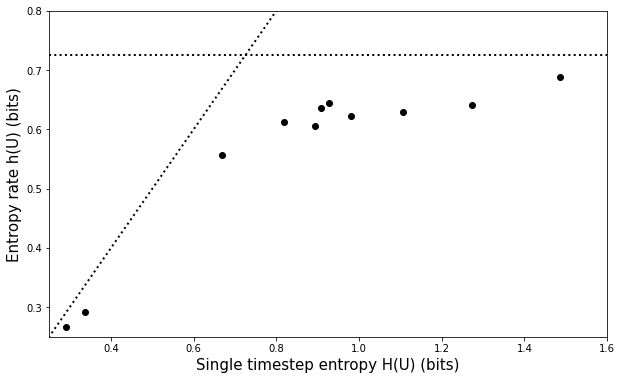

In [18]:
entropy_single_timestep_plot_lims = [0.25, 1.6]
entropy_rate_plot_lims = [0.25, 0.8]
plt.figure(figsize=(10, 6))

for rand_iter in range(number_random_repeats):
  for alphabet_size in [2, 4]:  ## the alphabet
    for number_mlp_layers in [1, 2, 3]:
      for activation_fn_ind, activation_fn in enumerate(['tanh', 'relu']):
        out_fname_npz = os.path.join(
            random_partition_outdir,
            f'{number_mlp_layers}layers_{activation_fn}_{alphabet_size}alphabet_{rand_iter}.npz')
        if not os.path.exists(out_fname_npz):
          continue
        pkl_dict = np.load(out_fname_npz, allow_pickle=True)
        entropy_single_timestep = pkl_dict['entropy_single_timestep']
        entropy_rate = pkl_dict['entropy_rate']
        entropy_rate_err = pkl_dict['entropy_rate_err']
        plt.errorbar(entropy_single_timestep, entropy_rate,
                     yerr=entropy_rate_err, markersize=6,
                     fmt='ko', elinewidth=3, ecolor='k', capsize=0)
## The two upper bounds of entropy rate: entropy for a single timestep and h_ks
plt.plot([0, 1], [0, 1], 'k', ls=':', lw=2)
plt.axhline(h_ks, color='k', ls=':', lw=2)

plt.xlim(entropy_single_timestep_plot_lims)
plt.ylim(entropy_rate_plot_lims)
plt.xlabel('Single timestep entropy H(U) (bits)', fontsize=15)
plt.ylabel('Entropy rate h(U) (bits)', fontsize=15)
plt.savefig(os.path.join(random_partition_outdir, 'scatter_plot.png'))
plt.show()

# Machine learning optimization (Figs 2 and 3)

Loaded ikeda!
I(U^tilde;X) = 1.020 bits; training stopped.
Estimating entropy rate.
Entropy rate=0.720698+-0.001216


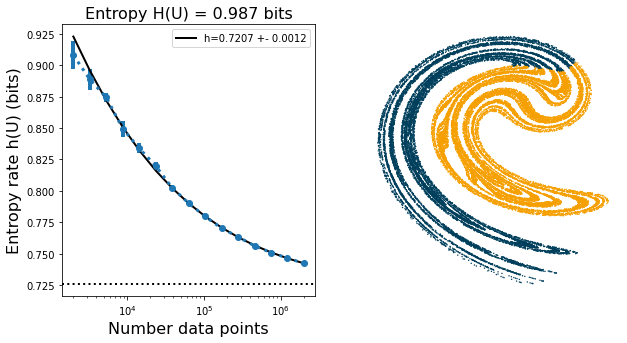

Saved! Time taken: 196.861 sec


In [17]:
'''
The proposed method: Optimize a measurement partition using the distributed IB

To reproduce the results of Fig 2, loop over `number_states` from 2 to 15, with 20 repeats per
For Fig 3, loop over `reference_timestep` from 0 to `number_states`-1 and change
`number_training_steps` from 20_000 (\dot{beta}_0 in the manuscript) to 40_000
'''
system_name = 'ikeda'
h_ks = entropy_rate_dict[system_name]

results_outdir = os.path.join(
    outputs_dir,
    f'trained_partitions_{system_name}')
if not os.path.exists(results_outdir):
  os.mkdir(results_outdir)

save_point_assignments = True

################################################################################
## Hyperparameters
################################################################################
# General training hparams
batch_size = 2048
learning_rate = 3e-4
number_training_steps = 20_000
optimizer_name = 'Adam'

################################################################################
# The distributed IB parameters: annealing, the dimension of the embedding space, the power to raise the KL to for the nonlinear IB
beta_start = 10
beta_end = 0.0001
information_bottleneck_embedding_dimension = 8
kl_loss_exponent = 2

################################################################################
# Architecture specs

# The positional encoding to help with the low dimensionality inputs
number_positional_encoding_frequencies = 10
pos_enc_frequencies = 2**np.arange(number_positional_encoding_frequencies)

# The IB arch whose input is the raw state and output is the distribution in IB space
info_bott_encoder_arch_spec = [128]*2

# The VQ network that takes as input the reparameterized IB point and outputs the (soft) partition assignment
vector_quant_arch_spec = [128]*2
alphabet_size = 2

# The aggregator that takes as input a sequence of measurement outcomes and outputs a latent vector for the InfoNCE loss
measurement_aggregator_arch_spec = [256]*2
number_states = 12

# The network that encodes the reference state directly to the InfoNCE space,
# where it will be matched with the embedding created with the sequence of measurements
reference_state_encoder_arch_spec = [256]*2
reference_timestep = 0

infonce_embedding_dimension = 32
infonce_similarity = 'l2sq'
infonce_temperature = 1.

activation_function = 'leaky_relu'  # use this for all of the networks

################################################################################
# The specs for the information estimation, not very important since we only use
# it to know when to stop training.  For a deeper dive into the meaning of these,
# see our previous https://arxiv.org/abs/2307.04755
info_evaluation_batch_size = 1024
info_evaluation_number_batches = 8
info_stopping_point = 1.
evaluate_info_every = number_training_steps//100

################################################################################
# Specs for the estimation of the entropy rate after training concludes
number_data_points_to_evaluate_entropy = np.logspace(
    np.log10(2000), np.log10(2_000_000), 15, dtype=np.int32)
number_rand_draws_for_entropy = 5

################################################################################
## Setup
################################################################################
# Load the data
data_arr_train = np.load(os.path.join(dataset_dir, f'{system_name}_train.npy'))
data_arr_eval = np.load(os.path.join(dataset_dir, f'{system_name}_eval.npy'))
tf_dataset_info = tf.data.Dataset.from_tensor_slices(data_arr_eval)
train_start_inds = np.arange(data_arr_train.shape[0]-number_states)

print(f'Loaded {system_name}!')

input_dimensionality = data_arr_train.shape[-1]


beta_var = tf.Variable(beta_start, dtype=tf.float32, trainable=False)

# Construct the networks
info_bott_encoder_params = {'encoder_arch_spec': info_bott_encoder_arch_spec,
                              'activation_function': activation_function,
                              'output_dimensionality': information_bottleneck_embedding_dimension,
                              'number_positional_encoding_frequencies': number_positional_encoding_frequencies}
info_bott_encoder = create_info_bott_encoder(input_dimensionality, **info_bott_encoder_params)
all_trainable_variables = info_bott_encoder.trainable_variables

vector_quantization_network = tf.keras.Sequential([tf.keras.layers.Input((information_bottleneck_embedding_dimension,))] +
                                        [tf.keras.layers.Dense(num_units, activation_function) for num_units in vector_quant_arch_spec] +
                                        [tf.keras.layers.Dense(alphabet_size)])  # we'll do the softmax manually so that we can impose a temperature

all_trainable_variables += vector_quantization_network.trainable_variables

measurement_aggregator_network = tf.keras.Sequential([tf.keras.layers.Input((number_states, alphabet_size)), tf.keras.layers.Reshape([-1])] +
                                        [tf.keras.layers.Dense(num_units, activation_function) for num_units in measurement_aggregator_arch_spec] +
                                        [tf.keras.layers.Dense(infonce_embedding_dimension)])

all_trainable_variables += measurement_aggregator_network.trainable_variables

reference_state_encoder = tf.keras.Sequential([tf.keras.layers.Input((input_dimensionality)), models.PositionalEncoding(pos_enc_frequencies)] +
                          [tf.keras.layers.Dense(num_units, activation_function) for num_units in reference_state_encoder_arch_spec] +
                          [tf.keras.layers.Dense(infonce_embedding_dimension)])
all_trainable_variables += reference_state_encoder.trainable_variables

optimizer = tf.keras.optimizers.get(optimizer_name)
optimizer.learning_rate = learning_rate

@tf.function
def match_batch(states_batch, training=True):
  # states_batch is [bs, number_states, input_dimensionality]
  states_batch_flattened = tf.reshape(states_batch, [-1, input_dimensionality])
  with tf.GradientTape() as tape:
    # Step 1: Encode to information bottleneck space, applying KL divergence penalty
    # and then using the reparameterization trick to sample from the distribution
    embs_mus, embs_logvars = tf.split(info_bott_encoder(states_batch_flattened), 2, axis=-1)

    kl = tf.reduce_mean(tf.reduce_sum(0.5 * (tf.square(embs_mus) + tf.exp(embs_logvars) - embs_logvars - 1.), axis=-1))
    # We average the KL over all states and all sequences in the batch
    # Then exponentiate it for the nonlinear IB
    # And finally multiply by the number of states L because the predictive model
    # gets to see this much "information" L times
    loss = beta_var * number_states * kl ** kl_loss_exponent

    reparameterized_embs = tf.random.normal(embs_mus.shape, mean=embs_mus, stddev=tf.exp(embs_logvars/2.))

    # Step 2: Apply soft vector quantization; we never needed a temperature
    # besides 1 during training and 0 during inference (equivalent to applying argmax instead of softmax),
    # so we don't create an explicit temperature here
    soft_discretized_embs = vector_quantization_network(reparameterized_embs)
    soft_discretized_embs = tf.nn.softmax(soft_discretized_embs, axis=-1)
    soft_discretized_embs = tf.reshape(soft_discretized_embs, [batch_size, -1, alphabet_size])

    # Step 3: Encode the sequence of measurements and the full-fidelity reference state
    # and match in InfoNCE space
    sequence_embedding = measurement_aggregator_network(soft_discretized_embs)
    reference_state_embedding = reference_state_encoder(states_batch[:, reference_timestep])

    similarity_matrix = utils.get_scaled_similarity(
        sequence_embedding,
        reference_state_embedding,
        infonce_similarity,
        infonce_temperature)
    # run the InfoNCE both ways -- meaning the negative samples are the rest of
    # the sequence embeddings in the batch first, and then the negative samples
    # are the rest of the reference state embeddings in the batch second
    loss_prediction = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(tf.range(batch_size),
                                                        similarity_matrix,
                                                        from_logits=True))
    loss_prediction += tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(tf.range(batch_size),
                                                        tf.transpose(similarity_matrix),
                                                        from_logits=True))
    loss_prediction = loss_prediction / 2.
    loss += loss_prediction
  if training:
    grads = tape.gradient(loss, all_trainable_variables)
    optimizer.apply_gradients(zip(grads, all_trainable_variables))
  return loss, loss_prediction, kl

################################################################################
## Training
################################################################################
ct = time.time()

loss_series, info_in_series, info_out_series = [[] for _ in range(3)]
for step_num in range(number_training_steps):
  # Anneal beta logarithmically between beta_start and beta_end
  beta_var.assign(np.exp(np.log(beta_start)+min(float(step_num)/number_training_steps, 1.)*(np.log(beta_end)-np.log(beta_start))))

  # Grab a batch full of sequences of length L
  batch_inds_starting_state = np.random.choice(train_start_inds, size=batch_size)
  batch_inds = np.stack([batch_inds_starting_state+offset for offset in range(number_states)], -1)
  states_batch = data_arr_train[batch_inds]

  loss_total, loss_prediction, kl = match_batch(states_batch, training=True)
  loss_series.append(loss_total.numpy())

  if ((step_num+1) % evaluate_info_every) == 0:
    measurement_info = np.float32(utils.estimate_mi_sandwich_bounds(
        info_bott_encoder,
        tf_dataset_info,
        evaluation_batch_size=info_evaluation_batch_size,
        number_evaluation_batches=info_evaluation_number_batches))/np.log(2)
    info_in_series.append(measurement_info)
    info_out_series.append((np.log2(batch_size)-loss_prediction/np.log(2))/number_states)
    if np.mean(measurement_info) >= info_stopping_point:
      print(f'I(U^tilde;X) = {np.mean(measurement_info):.3f} bits; training stopped.')
      break

################################################################################
## Partition characterization
################################################################################
print('Estimating entropy rate.')
chunk_size = 10_000
# Sample a fixed set of noise vectors to use (see Supp, Appendix C for discussion)
number_averaging_logits = 100
noise_vector = tf.random.normal((number_averaging_logits, 1, information_bottleneck_embedding_dimension))
# Symbolize the full evaluation dataset
symbolic_sequence = []
for data_ind_start in range(0, data_arr_eval.shape[0], chunk_size):
  data_ind_end = min(data_ind_start+chunk_size, data_arr_eval.shape[0]+1)
  embs_mus, embs_logvars = tf.split(info_bott_encoder(data_arr_eval[data_ind_start:data_ind_end]), 2, axis=-1)
  reparameterized_embs = tf.expand_dims(embs_mus, 0) + noise_vector * tf.expand_dims(tf.exp(embs_logvars/2.), 0)
  soft_discretized_embs = tf.reshape(vector_quantization_network(tf.reshape(reparameterized_embs, [-1, information_bottleneck_embedding_dimension])), [number_averaging_logits, -1, alphabet_size])
  assignments = np.argmax(soft_discretized_embs, axis=-1)
  symbolic_sequence.append(np.uint8(np.mean(assignments, axis=0)>0.5))
symbolic_sequence = np.concatenate(symbolic_sequence, 0)

entropy_single_timestep = utils.compute_entropy(symbolic_sequence)
entropy_rate_values = []

for number_data_points in number_data_points_to_evaluate_entropy:
  for _ in range(number_rand_draws_for_entropy):
    start_ind = np.random.choice(len(symbolic_sequence)-number_data_points)
    partial_seq = symbolic_sequence[start_ind:start_ind+number_data_points]
    entropy_rate_values.append(ctw.estimate_entropy(partial_seq, alphabet_size))
entropy_rate_values = np.reshape(entropy_rate_values, [-1, number_rand_draws_for_entropy])
# Use the statistics of the multiple values in the fitting
entropy_rate_values_mean = entropy_rate_values.mean(1)
entropy_rate_values_err = entropy_rate_values.std(1)

# Initial parameters, for h_inf (entropy_rate), gamma, c in Schurmann and Grassberger 1995:
# h(N) = h_inf + np.log2(N) / (N ** gamma) / np.abs(c)
p0 = [1, 0.5, 1]
fit_vals, pcov = optimize.curve_fit(utils.entropy_rate_scaling_ansatz,
                                    number_data_points_to_evaluate_entropy,
                                    entropy_rate_values_mean,
                                    p0=p0,
                                    sigma=entropy_rate_values_err)
fit_errs = np.sqrt(np.diag(pcov))
entropy_rate = fit_vals[0]
entropy_rate_err = fit_errs[0]
print(f'Entropy rate={entropy_rate:.6f}+-{entropy_rate_err:.6f}')

# Plot the entropy rate fit and the partition
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.errorbar(number_data_points_to_evaluate_entropy,
              entropy_rate_values_mean,
              yerr=entropy_rate_values_err,
              marker='o', markersize=6, ls=':', lw=3, elinewidth=4)

plt.plot(number_data_points_to_evaluate_entropy,
          utils.entropy_rate_scaling_ansatz(
            number_data_points_to_evaluate_entropy, *fit_vals),
          'k', lw=2,
          label=f'h={entropy_rate:.4f} +- {entropy_rate_err:.4f}')
plt.axhline(h_ks, ls=':', lw=2, color='k')
plt.xscale('log')
plt.xlabel('Number data points', fontsize=16)
plt.ylabel('Entropy rate h(U) (bits)', fontsize=16)
plt.title(f'Entropy H(U) = {entropy_single_timestep:.3f} bits', fontsize=16)
plt.legend()

plt.subplot(122)
number_scatter_points = 32000
positions_viz = data_arr_eval[:number_scatter_points]
symbolic_sequence_viz = symbolic_sequence[:number_scatter_points]
colors = [partition_colors[ind] for ind in symbolic_sequence_viz]
plt.scatter(*positions_viz.T, s=2, c=colors, marker='o', lw=0)
plt.axis('off')
out_fname_png = os.path.join(results_outdir, f'{system_name}_{number_training_steps}steps_L={number_states}_referenceTimestep{reference_timestep}.png')

plt.savefig(out_fname_png)
plt.show()

out_fname_npz = os.path.join(results_outdir, f'{system_name}_{number_training_steps}steps_L={number_states}_referenceTimestep{reference_timestep}.npz')
pkl_dict = dict(
      entropy_rate_values=entropy_rate_values,
      entropy_single_timestep=entropy_single_timestep,
      entropy_rate=entropy_rate,
      entropy_rate_err=entropy_rate_err)
if save_point_assignments:
  number_viz_points = 64_000
  visualization_arr = np.concatenate([data_arr_eval[:number_viz_points],
                                      np.reshape(symbolic_sequence[:number_viz_points], [-1, 1])], -1)

  pkl_dict['raw_data_points'] = data_arr_eval[:number_viz_points]
  pkl_dict['symbolic_sequence'] = symbolic_sequence[:number_viz_points]
np.savez(out_fname_npz, **pkl_dict)
print(f'Saved! Time taken: {time.time()-ct:.3f} sec')